# Run SQL Workloads

This Jupyter Notebook contains code to run SQL workloads across databases. 

The Db2 Data Management Console is more than a graphical user interface. It is a set of microservices that you can use to build custom applications to automate your use of Db2.

This Jupyter Notebook contains examples of how to use the Open APIs and the composable interface that are available in the Db2 Data Management Console. Everything in the User Interface is also available through an open and fully documented RESTful Services API. The full set of APIs are documented as part of the Db2 Data Management Console user interface. In this hands on lab you can connect to the documentation directly through this link: [Db2 Data Management Console RESTful APIs](http://localhost:11080/dbapi/api/index_enterprise.html). 

You can also embed elements of the full user interface into an IFrame by constructing the appropriate URL.

This hands on lab will be calling the Db2 Data Management Console as a service. However you can explore it through the user interface as well. Just click on the following link to try out the console that is already and setup in this lab: http://localhost:11080/console. If you have not already logged in you can use the following:
* Userid: db2inst1
* Password: db2inst1

### Import Helper Classes
For more information on these classes, see the lab: [Automate Db2 with Open Console Services](http://localhost:8888/notebooks/Db2_Data_Management_Console_Overview.ipynb)

In [1]:
%run ./dmc_setup.ipynb

### Db2 Data Management Console Connection
To connect to the Db2 Data Management Console service you need to provide the URL, the service name (v4) and profile the console user name and password as well as the name of the connection profile used in the console to connect to the database you want to work with. For this lab we are assuming that the following values are used for the connection:
* Userid: db2inst1
* Password: db2inst1
* Connection: sample

**Note:** If the Db2 Data Management Console has not completed initialization, the connection below will fail. Wait for a few moments and then try it again.

In [2]:
# Connect to the Db2 Data Management Console service
Console  = 'http://localhost:11080'
profile  = 'SAMPLE'
user     = 'DB2INST1'
password = 'db2inst1'

# Set up the required connection
profileURL = "?profile="+profile
databaseAPI = Db2(Console+'/dbapi/v4')

if databaseAPI.authenticate(user, password, profile) :
    print("Token Created")
else : 
    print("Token Creation Failed")
database = Console

Token Created


### Confirm the connection
To confirm that your connection is working you can check the status of the moitoring service. You can also check your console connection to get the details of the specific database connection you are working with. Since your console user id and password may be limited as to which databases they can access you need to provide the connection profile name to drill down on any detailed information for the database.

In [3]:
# List Monitoring Profile
r = databaseAPI.getProfile(profile)
json = databaseAPI.getJSON(r)
print(json)

{'name': 'SAMPLE', 'disableDataCollection': 'false', 'databaseVersion': '11.5.0', 'databaseName': 'SAMPLE', 'timeZone': '-50000', 'DB2Instance': 'db2inst1', 'db2license': 'AESE,DEC', 'isInstPureScale': 'false', 'databaseVersion_VRMF': '11.5.0.0', 'sslConnection': 'false', 'userProfileRole': 'OWNER', 'timeZoneDiff': '0', 'host': 'localhost', '_PROFILE_INIT_': 'true', 'dataServerType': 'DB2LUW', 'port': '50000', 'URL': 'jdbc:db2://localhost:50000/SAMPLE', 'edition': 'AESE,DEC', 'isInstPartitionable': 'false', 'dataServerExternalType': 'DB2LUW', 'capabilities': '["DSM_ENTERPRISE_LUW"]', 'OSType': 'Linux', 'location': ''}


### SQL Scripts Used to Generate Work
We are going to define a few scripts that we will use during this lab. 

In [4]:
sqlScriptWorkload1 = \
'''
WITH SALARYBY (DEPTNO, TOTAL) AS
    (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SALARY
        FROM EMPLOYEES EMP, DEPARTMENTS DEPT
        WHERE DEPT.DEPTNO = EMP.DEPTNO AND EMP.SALARY > 190000
        GROUP BY DEPT.DEPTNO
        ORDER BY DNO)
SELECT DEPT.DEPTNAME NAME, SALARYBY.TOTAL COST, DEPT.REVENUE, DEPT.REVENUE-SALARYBY.TOTAL PROFIT
FROM SALARYBY, DEPARTMENTS DEPT
WHERE DEPT.DEPTNO = SALARYBY.DEPTNO
AND REVENUE > TOTAL
ORDER BY PROFIT
'''
print("Defined Workload 1 Script")

Defined Workload 1 Script


In [5]:
sqlScriptWorkload2 = \
'''
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY
  FROM EMPLOYEES EMP, DEPARTMENTS DEPT 
  WHERE DEPT.DEPTNO = EMP.DEPTNO 
      AND EMP.SALARY < 50000
      AND YEAR(EMP.HIREDATA) > 2010
  GROUP BY DEPT.DEPTNO
  ORDER BY DNO;

SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY
  FROM EMPLOYEES EMP, DEPARTMENTS DEPT 
  WHERE DEPT.DEPTNO = EMP.DEPTNO 
      AND EMP.SALARY < 190000
      AND YEAR(EMP.HIREDATA) > 2010
  GROUP BY DEPT.DEPTNO
  ORDER BY DNO;

SELECT DEPT.DEPTNO, DEPT.REVENUE
  FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000;
'''
print("Defined Workload 2 Script")

Defined Workload 2 Script


### Creating a Routine to Run an SQL Script
To make things easier we can create reusable routines that will included everything we have developed so far. By running the next two steps, you create two routines that you can call by passing parameters to them. 

While we could create a single routine to run SQL and then display the results, we are creating two different routines so that we can display the results differently later in the lab. 

In [6]:
def runSQL(profile,user, password, sqlText):
    
    if databaseAPI.authenticate(user, password, profile) :

        # Run the SQL Script and return the runID for later reference 
        runID = databaseAPI.getJSON(databaseAPI.runSQL(sqlText))['id'] 

        # See if there are any results yet for this job
        json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))
        
        # If the REST call returns an error return the json with the error to the calling routine
        if 'errors' in json :
            return json
        # Append the results from each statement in the script to the overall combined JSON result set
        fulljson = json

        while json['results'] != [] or (json['status'] != "completed" and json['status'] != "failed") :
            json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))

            # Get the results from each statement as they return and append the results to the full JSON 
            for results in json['results'] :
                fulljson['results'].append(results)
            # Wait 250 ms for more results
            time.sleep(0.25) 
        return fulljson
    else :
        print('Could not authenticate')
print('runSQL routine defined')

runSQL routine defined


In [7]:
def displayResults(json):

    for results in json['results']:
        print('Statement: '+str(results['index'])+': '+results['command'])
        print('Runtime ms: '+str(results['runtime_seconds']*1000))
        if 'error' in results : 
            print(results['error'])
        elif 'rows' in results :
            df = pd.DataFrame(results['rows'],columns=results['columns'])
            print(df)
        else :
            print('No errors. Row Affected: '+str(results['rows_affected']))
        print()
print('displayResults routine defined')

displayResults routine defined


### Running multiple scripts across multiple databases - Summarized Results
Now that we have our tables created on both databases, we can run workloads and measure their performance. By repeatedly running the scripts across multiple databases in a single Db2 instance we can simulate a real database environemt. 

Instead of using the displayResults routine we are going to capture runtime metrics for each run of the SQL Query workloads so that we can analyze performance. The appendResults routine builds this dataframe with each pass.

runScripts lets use define the database connection profiles we want to run against, the scripts to run, and now many times to repeat the runs for each profile and for each script.

In [8]:
# This routine builds up a Data Frame containing the run results as we run workloads across databases
def appendResults(df, profile, json) :
    
    error = ''
    rows = 0
    if 'error' in json :
        print('SQL Service Failed')
    else :
        for results in json['results']:
            if 'error' in results : 
                error = results['error']
            if 'rows_affected' in results : 
                rows = results['rows_affected']
            df = df.append({'profile':profile,'index':results['index'], 'statement':results['command'], 'error':error, 'rows_affected': rows, 'runtime_ms':(results['runtime_seconds']*1000)}, ignore_index=True)
        return df
print('appendResults routine defined')

appendResults routine defined


In [9]:
# This routine runs multistatment scripts across multiple databases. 
# The scripts are run repeatedly for each profile (database)
def runScripts(profileList, scriptList, user, password, profileReps, scriptReps) :

    df = pd.DataFrame(columns=['profile', 'index', 'statement', 'error', 'rows_affected', 'runtime_ms'])
    
    for x in range(0, profileReps):
        print("Running repetition: "+str(x))
        for profile in profileList :
            print("  Running scripts against: "+profile)
            for y in range(0, scriptReps) :
                print("    Running script repetition: "+str(y))
                for script in scriptList :
                    json = runSQL(profile, user, password, script)
                    while 'errors' in json:
                        print('    * Trying again *')
                        json = runSQL(profile, user, password, script)
                    df = appendResults(df, profile, json)
                        
    return df
print('runScripts routine defined')

runScripts routine defined


The next cell loops through a list of databases as well as a list of scripts and run then repeatedly. You an set the number of times the scripts are run against each database and the number of times the runs against both databases is repeated.

In [10]:
profileList = ['SAMPLE','HISTORY']
scriptList = [sqlScriptWorkload1, sqlScriptWorkload2]
user = 'DB2INST1'
password = 'db2inst1'
profileReps = 20
scriptReps = 5

df = runScripts(profileList, scriptList, user, password, profileReps, scriptReps)

display(df)

Running repetition: 0
  Running scripts against: SAMPLE
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
    Running script repetition: 4
  Running scripts against: HISTORY
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
    Running script repetition: 4
Running repetition: 1
  Running scripts against: SAMPLE
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
    Running script repetition: 4
    * Trying again *
  Running scripts against: HISTORY
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
    Running script repetition: 4
Running repetition: 2
  Running scripts against: SAMPLE
    Running script repetition: 0
    Running script repetition: 1
    Running scr

    Running script repetition: 2
    Running script repetition: 3
    Running script repetition: 4
  Running scripts against: HISTORY
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
    Running script repetition: 4


,profile,index,statement,error,rows_affected,runtime_ms
0,SAMPLE,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT ...",,0,446.999997
1,SAMPLE,0,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",,0,1480.000019
2,SAMPLE,1,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",,0,759.999990
3,SAMPLE,2,"SELECT DEPT.DEPTNO, DEPT.REVENUE\n FROM DEPAR...",,0,3.000000
4,SAMPLE,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT ...",,0,601.999998
...,...,...,...,...,...,...
797,HISTORY,2,"SELECT DEPT.DEPTNO, DEPT.REVENUE\n FROM DEPAR...",,0,1.000000
798,HISTORY,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT ...",,0,347.999990
799,HISTORY,0,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",,0,219.999999
800,HISTORY,1,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",,0,321.000010


### Analyze Results
Now we can use the results in the dataframe to look at the results statistically. First we can see the average runtime for each statement across the databases.

In [11]:
print('Mean runtime in ms')
pd.set_option('display.max_colwidth', 100)
stmtMean = df.groupby(['statement']).mean()
print(stmtMean)

Mean runtime in ms
                                                                                                      runtime_ms
statement                                                                                                       
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  573.940299
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  529.363183
SELECT DEPT.DEPTNO, DEPT.REVENUE\n  FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000                1.785000
WITH SALARYBY (DEPTNO, TOTAL) AS\n    (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SALA...  412.579999


We can also display the total runtime for each statement across databases.

In [12]:
print('Total runtime in ms')
pd.set_option('display.max_colwidth', 100)
stmtSum = df.groupby(['statement']).sum()
print(stmtSum)

Total runtime in ms
                                                                                                         runtime_ms
statement                                                                                                          
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  115362.000003
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  106401.999876
SELECT DEPT.DEPTNO, DEPT.REVENUE\n  FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000                 357.000011
WITH SALARYBY (DEPTNO, TOTAL) AS\n    (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SALA...   82515.999869


We can even graph the total run time for all the statements can compare database performance. Since there are more rows in the employees table in the SAMPLE database it takes longer for the queries to run.

Mean runtime in ms


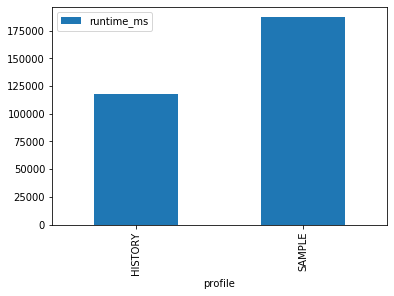

In [13]:
print('Mean runtime in ms')
pd.set_option('display.max_colwidth', 100)
profileSum = df.groupby(['profile']).sum()
profileSum.plot(kind='bar')
plt.show()

#### Credits: IBM 2019, Peter Kohlmann [kohlmann@ca.ibm.com]